# FIT5201 Data analysis algorithms S1 2019 
# Assignment 1
#### Student Name: Nisheeth Shah
#### Student ID: 29599644
#### Email Id: nsha0020@student.monash.edu

Date: 04/04/2019

Environment: R version 3.4.3.
Libraries used:
- reshape2
- ggplot2

# Section B. Prediction Uncertainty with Bootstrapping
## Question 3: Bootstrapping

    I. Handle bootstrapping for KNN regression.
    II. Apply bootstrapping for KNN regression with times = 100 (the number of subsets), size = 25 (the size of each subset), and change K=1,..,20.
    III. Explain how does the test error and its uncertainty behave as K increases.
    IV. Apply bootstrapping for KNN regression with K=10 (the neighbourhood size), size = 25 (the size of each subset), and change times = 10, 20, 30,.., 200 (the number of subsets).
    V. Explain how does the test error and its uncertainty behave as the number of subsets in bootstrapping increases.

### Importing Libraries

In [14]:
library(reshape2)
library(ggplot2)

### Read train and test datasets

In [15]:
# read csv files
train <- read.csv("Task1B_train.csv")
test <- read.csv("Task1B_test.csv") 

# Set data and labels for train and test sets
train.data <-train[,-5]
test.data <- test[,-5]
train.label <- train[,5]
test.label <-test[,5]

### I. Bootstrapping

In [16]:
# a function that generates sample indexes based on bootstrap technique
boot <- function (original.size=100, sample.size=original.size, times=100){
    indx <- matrix(nrow=times, ncol=sample.size)
    for (t in 1:times){
        indx[t, ] <- sample(x=original.size, size=sample.size, replace = TRUE)
    }
    return(indx)
}
# lets try once to see if our function is working properly 
boot(100, 10, 5)

11,12,73,75,81,2,47,40,92,6
51,47,9,79,79,73,72,32,72,2
74,43,23,60,42,64,85,5,97,62
95,21,100,9,67,1,18,54,15,83
24,82,47,52,46,88,28,6,40,28


### KNN Regressor function

knn(train.data, train.label, test.data, K=3) which takes the training data and their labels (continuous values), the test set, and the size of the neighborhood (K). It returns the regressed values for the test data points. When choosing the neighbors, we use the Euclidean distance function to measure the distance between a pair of data points.

In [17]:
# KNN function (distance should be one of euclidean, maximum, manhattan, canberra, binary or minkowski)
knn <- function(train.data, train.label, test.data, K=3, distance = 'euclidean'){
    
    #count number of train samples
    train.len <- nrow(train.data)
    
    #count number of test samples
    test.len <- nrow(test.data)
    
    #calculate distances between samples
    dist <- as.matrix(dist(rbind(test.data, train.data), method= distance))[1:test.len, (test.len+1):(test.len+train.len)]
    
    #for each test sample...
    for (i in 1:test.len){
        ### ...find its K nearest neighbours from training sampels...
        nn <- as.data.frame(sort(dist[i,], index.return = TRUE))[1:K,2]
        
        ###... and calculate the predicted labels according to the majority vote
        test.label[i]<- (mean(train.label[nn]))
    }
    
    ## return the class labels as output
    return (test.label)
}

### II. Bootstrapping for KNN regression 

with L = 100 (the number of subsets), N = 30 (the size of each subset), and K=1,..,20 (the neighbourhood size). Below code block is time consuming...

In [18]:
# fix the parameters (20, 100, 25)
K <- 20           # Maximum K for KNN 
L <- 100           # number of datasets
N <- 25          # size of datasets

# generate bootstrap indices:
boot.indx <- boot(nrow(train.data), N, L)

# a dataframe to track and record errors
error <- data.frame('K'=1:K, 'L'=1:L, 'test'=rep(0,L*K))

# THIS MAY TAKE A FEW MINUTES TO COMPLETE
## for every k values:
for (k in 1: K){
    
    # for every dataset sizes:
    for (l in 1:L){
        
        # calculate iteration index i
        i <- (k-1)*L+l
        
        # save sample indices that were selected by bootstrap
        indx <- boot.indx[l,]
        
        # save the value of k and l
        error[i,'K'] <- k
        error[i,'L'] <- l
        
        # calculate and record errors
        error[i,'test'] <-  sqrt(mean((knn(train.data[indx, ], train.label[indx], test.data, K=k) - test.label)^2))
        
    } 
}

In [19]:
# Lets print the value of k which gives minimum test error
which(error[,3]==min(error[,3]))

[1] 183

### Boxplot
Where the x-axis is K , and the y-axis is the average error (and the uncertainty around it) corresponding to each K

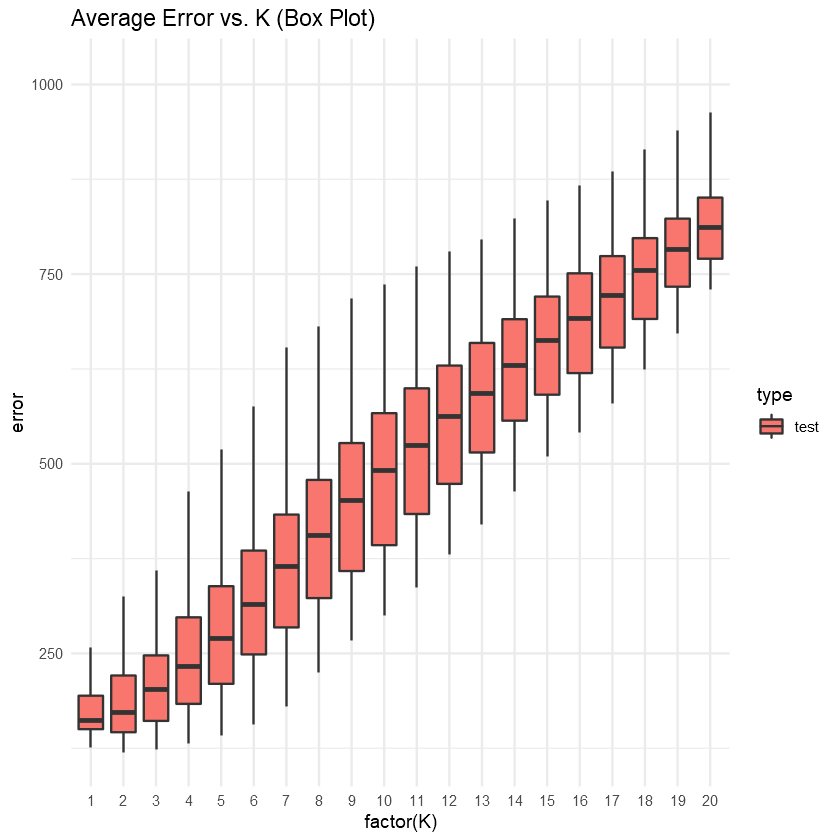

In [20]:
# Reshape the data
error.m <- melt(error, id=c('K', 'L'))
names(error.m) <- c('K', 'L', 'type', 'error')

ggplot(data=error.m[error.m$type=='test',], aes(factor(K), error,fill=type)) + 
    geom_boxplot(outlier.shape = NA)  + 
    scale_color_discrete(guide = guide_legend(title = NULL)) + 
    ggtitle('Average Error vs. K') + 
    theme_minimal()
options(warn=-1) # ignore the warnings due to outliers

### III. How does the test error and its uncertainty behave as K increases?
From the above plot, we can see that as the value of K increases, the test error and uncertainty increases. <br>
Furthermore, when K is high, uncertainty decreases whereas test error increases.

### IV. Bootstrapping for KNN regression 

with K=10 (the neighbourhood size), size = 25 (the size of each subset), and change times = 10, 20, 30,.., 200 (the number of subsets)

In [21]:
K <- 10           # Maximum K for KNN 
N <- 25          # size of datasets

# Store the errors in df
times.avg.error <- data.frame()

# for loop for times = 10, 20, 30,.., 200
for(L in seq(from=10, to=200, by=10)) 
{
  boot.indx <- boot(nrow(train.data), N, L)
  
    for (l in 1:L){
    
    # calculate iteration index i
    i <- (10-1)*L+l
    
    # save sample indices that were selected by bootstrap
    indx <- boot.indx[l,]
    
    # save the value of k and l
    times.avg.error[i,'K'] <- 10
    times.avg.error[i,'L'] <- L
    
    # calculate and record errors
    times.avg.error[i,'test'] <-  sqrt(mean((knn(train.data[indx, ], train.label[indx], test.data, K=k) - test.label)^2))
    
  }
    
}


### Boxplot
Where the x-axis is ‘times’,and the y-axis is the average error (and the uncertainty around it) corresponding to each value of ‘times’

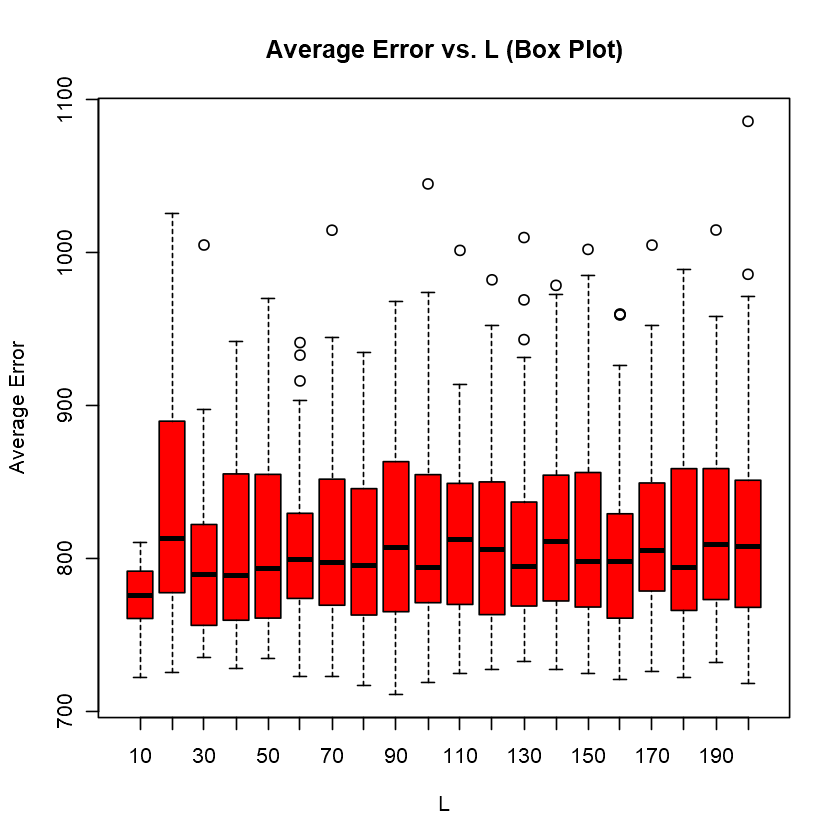

In [22]:
times.avg.error.m <- melt(times.avg.error, id=c('K', 'L')) # reshape for visualization
names(times.avg.error.m) <- c('K', 'L', 'type', 'times.avg.error')

boxplot(times.avg.error~L, times.avg.error.m, main="Average Error vs. L (Box Plot)", 
        xlab="L", ylab="Average Error", col = "Red")

### V. How does the test error and its uncertainty behave as the number of subsets in bootstrapping increases?

From the above box plot, the error is not changed enough after bootstrapping. <br>
Different subsets have different errors.